In [143]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Функция преобразования в градации серого
def grayscale(img):
    """Применяет преобразование в градации серого."""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Функция применения преобразования Кенни для нахождения краёв
def canny(img, low_threshold, high_threshold):
    """Применяет преобразование Кенни."""
    return cv2.Canny(img, low_threshold, high_threshold)

# Функция размытия изображения с использованием гауссова фильтра
def gaussian_blur(img, kernel_size):
    """Применяет гауссово размытие с заданным размером ядра."""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Функция выделения области интереса на изображении
def region_of_interest(img, vertices):
    """
    Применяет маску изображения.
    Оставляет только ту область изображения, которая определена многоугольником, заданным вершинами `vertices`.
    Остальная часть изображения становится чёрной.
    """
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Рисует линии на изображении."""
    if lines is not None:  
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """Применяет преобразование Хафа и возвращает линии и их bounding boxes."""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    bounding_boxes = []
    if lines is not None:
        filtered_lines = []
        for line in lines:
            for x1, y1, x2, y2 in line:
                # Проверка на горизонтальные линии
                if abs(y2 - y1) > 10:  # Допустимый порог для наклона
                    filtered_lines.append(line)
                    # Вычисляем bounding box для линии
                    x_min = min(x1, x2)
                    y_min = min(y1, y2)
                    x_max = max(x1, x2)
                    y_max = max(y1, y2)
                    bounding_boxes.append((x_min, y_min, x_max, y_max))
        
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)  
        draw_lines(line_img, filtered_lines)  
    else:
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    return line_img, bounding_boxes

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """Наложение изображений с параметрами для прозрачности."""
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Основная программа для обработки изображения
def process_image(image):
    # Шаг 1: Преобразование в градации серого
    gray = grayscale(image)
    print("Шаг 1: Преобразование в градации серого")
    plt.imshow(gray, cmap='gray')
    plt.title('Градации серого')
    plt.axis('off')
    plt.show()

    # Шаг 2: Применение гауссова размытия для уменьшения шума
    blurred = gaussian_blur(gray, 5)
    print("Шаг 2: Применение гауссова размытия")
    plt.imshow(blurred, cmap='gray')
    plt.title('Гауссово размытие')
    plt.axis('off')
    plt.show()

    # Шаг 3: Применение детектора краёв Кенни
    edges = canny(blurred, 20, 100)
    print("Шаг 3: Применение детектора краёв Кенни")
    plt.imshow(edges, cmap='gray')
    plt.title('Края после Кенни')
    plt.axis('off')
    plt.show()

    # Шаг 4: Определение области интереса (вычёркиваем 20% сверху и снизу)
    height = image.shape[0]
    width = image.shape[1]

    # Вычисляем 20% сверху и снизу
    top_cut = int(height * 0.65)
    bottom_cut = int(height * 0.9)

    # Определяем вершины для области интереса
    vertices = np.array([[ 
        (0, top_cut),  # Левая верхняя точка
        (width, top_cut),  # Правая верхняя точка
        (width, bottom_cut),  # Правая нижняя точка
        (0, bottom_cut)  # Левая нижняя точка
    ]], dtype=np.int32)

    # Применяем маску, чтобы оставить только центральную часть изображения
    masked_edges = region_of_interest(edges, vertices)
    print("Шаг 4: Применение маски области интереса")
    plt.imshow(masked_edges, cmap='gray')
    plt.title('Маска области интереса')
    plt.axis('off')
    plt.show()

    # Шаг 5: Применение преобразования Хафа для нахождения линий и вычисления bounding boxes
    hough_img, bounding_boxes = hough_lines(masked_edges, rho=1, theta=np.pi/180, threshold=50, min_line_len=100, max_line_gap=150)
    print("Bounding boxes:", bounding_boxes)
    
    # Наложение найденных линий на исходное изображение
    result = weighted_img(hough_img, image)

    # Рисуем bounding boxes на изображении для наглядности
    for (x_min, y_min, x_max, y_max) in bounding_boxes:
        cv2.rectangle(result, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Результат с наложением bounding boxes')
    plt.axis('off')
    plt.show()

    return result, bounding_boxes


Шаг 1: Преобразование в градации серого


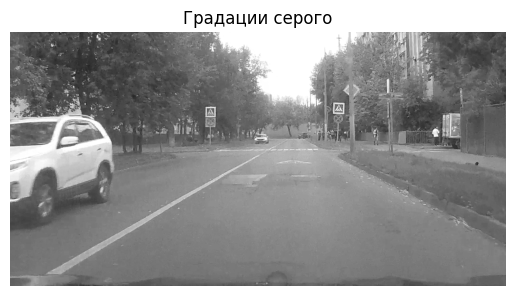

Шаг 2: Применение гауссова размытия


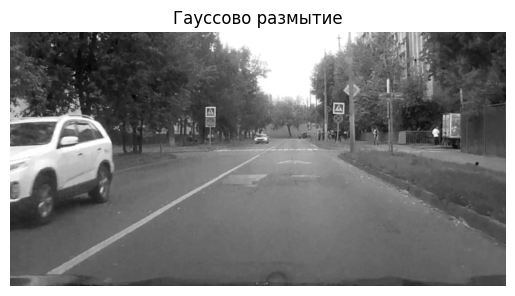

Шаг 3: Применение детектора краёв Кенни


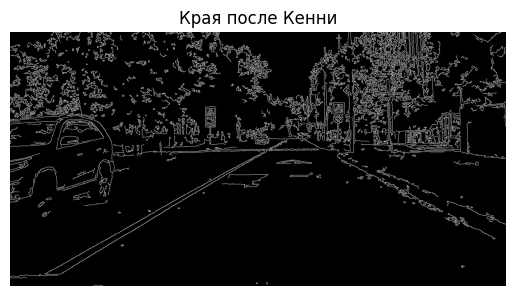

Шаг 4: Применение маски области интереса


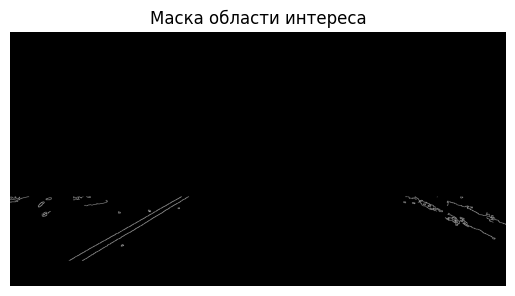

Bounding boxes: [(213, 485, 525, 672), (279, 485, 502, 613), (213, 485, 523, 671), (174, 593, 312, 672), (1165, 485, 1425, 606), (318, 485, 503, 592), (1190, 485, 1384, 584), (1193, 488, 1426, 607), (1256, 485, 1435, 554), (1163, 485, 1425, 607), (1184, 489, 1388, 588)]


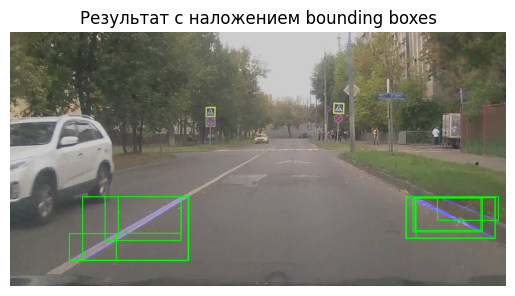

(array([[[ 77,  95, 116],
         [ 75,  94, 114],
         [ 78,  92, 114],
         ...,
         [ 52,  75,  72],
         [ 52,  75,  72],
         [ 51,  74,  70]],
 
        [[ 75,  99, 104],
         [ 78, 102, 107],
         [ 79, 104, 106],
         ...,
         [ 50,  77,  73],
         [ 49,  76,  72],
         [ 49,  76,  72]],
 
        [[ 74,  98, 103],
         [ 74,  97, 102],
         [ 74,  98, 100],
         ...,
         [ 50,  77,  73],
         [ 50,  77,  73],
         [ 49,  76,  72]],
 
        ...,
 
        [[ 87,  87,  82],
         [ 87,  87,  82],
         [ 87,  87,  82],
         ...,
         [ 82,  89,  90],
         [ 82,  89,  90],
         [ 82,  89,  90]],
 
        [[ 89,  87,  82],
         [ 89,  87,  82],
         [ 89,  87,  82],
         ...,
         [ 82,  89,  90],
         [ 82,  89,  90],
         [ 82,  89,  90]],
 
        [[ 89,  87,  82],
         [ 89,  87,  82],
         [ 89,  87,  82],
         ...,
         [ 80,  87,  88],
  

In [ ]:
# Загружаем изображение
image = cv2.imread('D:\\traffic_violation_checker\\data\\img\\example.png')

# Обработка изображения 
process_image(image)
